# Training a Conditional MAF

With `JaxILI`, it is possible to train a normalizing flow by hand without using the `NPE` or `NLE` interface. This can be useful to have a better control of the training loop.

This notebook shows how one can train a normalizing flow without using the API provided by `JaxILI`.

In [1]:
import os

import jax
import jax.numpy as jnp
import jax_dataloader as jdl
import numpy as numpy

from jaxili.utils import create_data_loader  #To create data loaders
from jaxili.train import TrainerModule #To perform the training
from jaxili.model import ConditionalMAF #The model used to learn the target distribution
from jaxili.loss import loss_nll_npe #Losses to train NFs with different configurations are provided

print("Device used by jax:", jax.devices())

2025-03-31 22:14:46.506375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743452086.548494   63436 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743452086.557564   63436 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device used by jax: [CudaDevice(id=0)]


In [2]:
#Let's use the same simulator than previously
n_dim = 3

def simulator(theta, rng_key):
    batch_size = theta.shape[0]
    return theta + jax.random.normal(rng_key, shape=(batch_size, n_dim))*0.1

In [3]:
master_key = jax.random.PRNGKey(0)
num_samples = 10_000

theta_key, master_key = jax.random.split(master_key)

#Draw the parameters from the prior
theta = jax.random.uniform(theta_key, shape=(num_samples, n_dim), minval=jnp.array([-2., -2., -2.]), maxval=jnp.array([2., 2., 2.]))

sim_key, master_key = jax.random.split(master_key)
x = simulator(theta, sim_key)

print("Parameters shape:", theta.shape)
print("Data shape:", x.shape)

Parameters shape: (10000, 3)
Data shape: (10000, 3)


Let's first create train, validation and test sets.

In [4]:
train_set = jdl.ArrayDataset(theta[:7000], x[:7000])
val_set = jdl.ArrayDataset(theta[7000:9000], x[7000:9000])
test_set = jdl.ArrayDataset(theta[:9000], x[:9000])

We can then get dataloaders.

In [5]:
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size=128
)

We then have to specify all the hyperparameters for the training.

In [6]:
#Specify a checkpoint to save the weights of the neural network
CHECKPOINT_PATH = "."
#Turn it into an absolut path
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

loss_fn = loss_nll_npe

model_hparams_maf = {
    'n_in': n_dim,
    'n_cond': n_dim,
    'n_layers': 5,
    'layers': [50, 50],
    'activation': jax.nn.relu,
    'use_reverse': True,
    'seed' : 42
}

optimizer_hparams = { #hyperparameters of the optimizer for training
    'lr': 5e-4,
    'optimizer_name': 'adam'
}

logger_params = {
    'base_log_dir': CHECKPOINT_PATH
}

check_val_every_epoch = 1

debug = False

nde_class= "NPE"

We then create a `TrainerModule` object that will perform the training. This module is created automatically when using the classes `NPE` or `NLE`.

In [7]:
trainer_maf_npe = TrainerModule(
    model_class=ConditionalMAF,
    model_hparams=model_hparams_maf,
    optimizer_hparams=optimizer_hparams,
    loss_fn=loss_fn,
    exmp_input=next(iter(train_loader)),
    logger_params=logger_params,
    debug=debug,
    check_val_every_epoch=check_val_every_epoch,
    nde_class=nde_class    
)

#Train the Neural Density Estimator
metrics_maf_npe = trainer_maf_npe.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=500, patience=20
)

Could not tabulate model: 


Epochs: Val loss -2.660/ Best val loss -2.687:  19%|█▉        | 97/500 [00:30<02:07,  3.17it/s]

Neural network training stopped after 98 epochs.
Early stopping with best validation metric: -2.687150239944458
Best model saved at epoch 85
Early stopping parameters: min_delta=0.001, patience=20


The trained model can then be used to sample from or compute the log-probability of the learned distribution.

In [8]:
model_maf_npe = trainer_maf_npe.bind_model()

#Let's first create an observation
obs_key, master_key = jax.random.split(master_key)
fiducial = jnp.array([[0.5, 0.5, 0.5]])
obs = simulator(fiducial, obs_key)

sample_key, master_key = jax.random.split(master_key)
samples_maf_npe = model_maf_npe.sample(
    obs, num_samples=10000, key=sample_key
)

In [9]:
#We will use getdist to visualise the results
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
%matplotlib inline

Removed no burn in


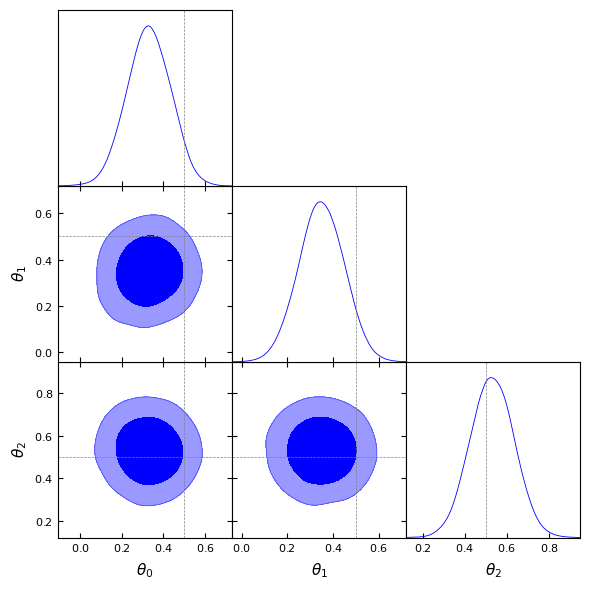

In [10]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples_maf_npe, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

## Reloading a trained network

After training, it can be useful to reload a model with the trained weights to save an unnecessary step of training. This is allowed by the class `TrainerModule`.

In [11]:
trainer_maf_npe = TrainerModule.load_from_checkpoints(
    model_class=ConditionalMAF,
    checkpoint=os.path.abspath(CHECKPOINT_PATH)+"/ConditionalMAF/version_0/",
    exmp_input=next(iter(train_loader))
)

Could not tabulate model: 


In [12]:
model_maf_npe = trainer_maf_npe.bind_model()

samples_maf_npe = model_maf_npe.sample(
    obs, num_samples=10000, key=sample_key
)

Removed no burn in


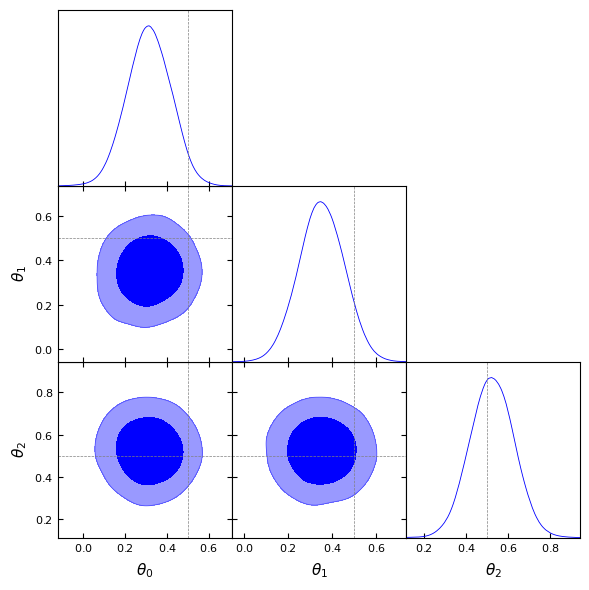

In [13]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples_maf_npe, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

We recover the same posterior as the same observation has been used with the same seed and that the weight of the network have been recovered correctly.